```
Copyright (c) 2024-2025 National Institute of Advanced Industrial Science and Technology (AIST)
All rights reserved.
This software is released under the MIT License.
http://opensource.org/licenses/mit-license.php
```

## Introduction
In this notebook you will learn the advanced use of the ef_crafter and the ef_capture.

1. [Simultaneously send frames from port0 to port1 and from port2 to port1 and record the send and receive times](#1.-Simultaneously-send-frames-from-port0-to-port1-and-from-port2-to-port1-and-record-the-send-and-receive-times)
   1. [Make initial settings](#1-A.-Make-initial-settings)
   2. [Set up the AXIS Switch](#1-B.-Set-up-the-AXIS-Switch)
   3. [Update ef_capture setting](#1-C.-Update-ef_capture-setting)
   4. [Prepare send frames](#1-D.-Prepare-send-frames)
   5. [Send frames from port0 and port2 simultaneously, in repeat mode](#1-E.-Send-frames-from-port0-and-port2-simultaneously,-in-repeat-mode)
   6. [Transfer the recorded timestamps to the host computer](#1-F.-Transfer-the-recorded-timestamps-to-the-host-computer)
   7. [Check the recorded timestamps](#1-G.-Check-the-recorded-timestamps)
   8. [Evaluate latency and throughput for each input port](#1-H.-Evaluate-latency-and-throughput-for-each-input-port)
2. [Send frames by adjusting the frame interval to match the target transfer rate](#2.-Send-frames-by-adjusting-the-frame-interval-to-match-the-target-transfer-rate)
   1. [Update internal switch configuration](#2-A.-Update-internal-switch-configuration)
   2. [Update ef_capture setting](#2-B.-Update-ef_capture-setting)
   3. [Prepare send frames (Constant rate)](#2-C.-Prepare-send-frames-(Constant-rate))
   4. [Send frames from port0 to port1, in repeat mode](#2-D.-Send-frames-from-port0-to-port1,-in-repeat-mode)
   5. [Transfer the recorded timestamps to the host computer](#2-E.-Transfer-the-recorded-timestamps-to-the-host-computer)
   6. [Evaluate latency and throughput for each input port](#2-F.-Evaluate-latency-and-throughput-for-each-input-port)
3. [Sends frames at a random transmission rate that follows an exponential distribution](#3.-Sends-frames-at-a-random-transmission-rate-that-follows-an-exponential-distribution)
   1. [Generate random numbers that follow an exponential distribution](#3-A.-Generate-random-numbers-that-follow-an-exponential-distribution)
   2. [Prepare send frames (Exponential distribution)](#3-B.-Prepare-send-frames-(Exponential-distribution))
   3. [Send frames from port0 to port1, in repeat mode](#3-C.-Send-frames-from-port0-to-port1,-in-repeat-mode)
   4. [Transfer the recorded timestamps to the host computer](#3-D.-Transfer-the-recorded-timestamps-to-the-host-computer)
   5. [Evaluate latency and throughput](#3-E.-Evaluate-latency-and-throughput)

In [1]:
import argparse
import tsn_efcc
import pyxsdb
import sys

FREQ_MHZ = 125.0

## 1. Simultaneously send frames from port0 to port1 and from port2 to port1 and record the send and receive times
Please connect Port0 (MAC0), Port1 (MAC1) and Port2 (MAC2) of the TSN-EFCC to network switch as shown below.  
(Optional) If you connect Port3 (MAC3) and the NIC of the host PC, you can see the frames in Wireshark.  
![overwiew_sample_design-1g_example_configuration3.drawio.svg](img/overwiew_sample_design-1g_example_configuration3.drawio.svg)

### 1-A. Make initial settings

Set JTAG2AXI target. As default, this target is expected to be target 3.  
If you want to different target value, change the next value.

In [2]:
xsdb_target = 3

In [3]:
# Open xsdb device to access TSN-EFCC
xsdb = pyxsdb.PyXsdb()
xsdb.connect()
xsdb.target(xsdb_target)

# Get the default address table object
default_addr_table = tsn_efcc.default_tsn_efcc_address_table()
print(f'{default_addr_table}\n')

# Initialize AxisNetSwitch object
switch = tsn_efcc.AxisNetSwitch(xsdb, xsdb_target, default_addr_table)

# Initialize the ef_crafter
crafter = tsn_efcc.EFCrafter(xsdb, xsdb_target, default_addr_table)

# Just to be sure, stop ef_crafter
crafter.reset(0xff)

xsdb server launched.
TsnEfccAddressTable(ef_crafter=1593835520, ef_crafter_buffers=(1342177280, 1358954496, 1375731712, 1392508928), ef_crafter_ip_tables=(1409286144, 1426063360, 1442840576, 1459617792), ef_crafter_mac_tables=(1476395008, 1493172224, 1509949440, 1526726656), ef_capture_tx_ctrl=(1325400064, 1325465600, 1325531136, 1325596672), ef_capture_rx_ctrl=(1325662208, 1325727744, 1325793280, 1325858816), ef_capture_buffers=(1073741824, 1090519040, 1107296256, 1124073472), ef_capture_buffer_switch=(1326448640, 1326514176, 1326579712, 1326645248), axis_net_switch=1610612736, commit_hash=1048576)



### 1-B. Set up the AXIS Switch

In this test, we connect ef_crafter0(port 4) to TX0(port 0) and ef_crafter2(port 6) to TX2(port 2).  
In addition, as FDB updates require the sending of frames from the receive port to the network switch, connect Frame Generator1 (port 5) to TX1 (port 1).

If you want to optionally capture frames on the host PC, uncomment the following formula and also connect RX1 (port 1) to TX3 (port 3).  
However, if you connect MAC3 to the network switch, never connect RX1 to TX3. Otherwise, the frames output from TX3 will be sent back to RX1, creating a loop.

Other input ports are disconnected from output port.

In [4]:
switch.start_config()
switch.connect(4, 0)   # crafter 0 -> MAC 0 TX
switch.connect(6, 2)   # crafter 2 -> MAC 2 TX
switch.connect(5, 1)   # crafter 1 -> MAC 1 TX (for FDB learning)
# switch.connect(1, 3)   # MAC 1 RX -> MAC 3 TX (optional)
switch.commit()

# show current switch status
switch.show_configuration()

input MAC0-RX -> Drop
input MAC1-RX -> Drop
input MAC2-RX -> Drop
input MAC3-RX -> Drop
input EFCrafter0 -> MAC0-TX
input EFCrafter1 -> MAC1-TX
input EFCrafter2 -> MAC2-TX
input EFCrafter3 -> Drop


### 1-C. Update ef_capture setting

Configure capture (2 TX, 1 RX)

In [5]:
capture0 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 0)
capture1 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 1)
capture2 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 2)
capture0.select_port('tx')    # use capture of MAC 0 to record TX timestamp
capture1.select_port('rx')    # use capture of MAC 1 to record RX timestamp
capture2.select_port('tx')    # use capture of MAC 2 to record TX timestamp

# Just to be sure, let's reset the timestamp recording status
capture0.reset()
capture1.reset()
capture2.reset()

### 1-D. Prepare send frames
To ensure that the total bandwidth is just over 1Gbps, let's generate frames to be transmitted at about 666Mbps from port0 and 750Mbps from port2.

Firstly, we create a frame information which flows Port0 -> Port1.  
Transmitting one NOP frame for every two normal frames results in a 2/3 transfer rate.

In [6]:
frame0 = tsn_efcc.Frame('Frame0').ether(dst=2, src=1).ipv4(dst=2, src=1).udp(dst=2000, src=1000).payload(length=1024)

eol_frame = tsn_efcc.Frame.eol()
crafter.set_frame(port=0, index=0, frame=frame0)
crafter.set_frame(port=0, index=1, frame=frame0)
crafter.set_frame(port=0, index=2, frame=frame0.clone().nop())
crafter.set_frame(port=0, index=3, frame=eol_frame)

# Dump the frame information pushed to ef_crafter
for frame in crafter.get_frames(port=0):
    print(frame)

Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0001.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0002.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024).Nop()
EOL()


Next, we will create the frame information that will flow from Port2 to Port1.  
Transmitting one NOP frame for every three normal frames results in a 3/4 transfer rate.

In [7]:
frame2 = tsn_efcc.Frame('Frame2').ether(dst=2, src=3).ipv4(dst=2, src=3).udp(dst=2002, src=1002).payload(length=1024)

crafter.set_frame(port=2, index=0, frame=frame2)
crafter.set_frame(port=2, index=1, frame=frame2)
crafter.set_frame(port=2, index=2, frame=frame2)
crafter.set_frame(port=2, index=3, frame=frame2.clone().nop())
crafter.set_frame(port=2, index=4, frame=eol_frame)

# Dump the frame information pushed to ef_crafter
for frame in crafter.get_frames(port=2):
    print(frame)

Frame0000.ETHER(dst=2, src=3).IPV4(dst=2, src=3).UDP(dst=2002, src=1002).Payload(length=1024)
Frame0001.ETHER(dst=2, src=3).IPV4(dst=2, src=3).UDP(dst=2002, src=1002).Payload(length=1024)
Frame0002.ETHER(dst=2, src=3).IPV4(dst=2, src=3).UDP(dst=2002, src=1002).Payload(length=1024)
Frame0003.ETHER(dst=2, src=3).IPV4(dst=2, src=3).UDP(dst=2002, src=1002).Payload(length=1024).Nop()
EOL()


In order for the FDB to learn port 1, a frame is also created to be output from port1.  
The destination can be port0 or port2, but here port0 is assumed.

In [8]:
frame1 = tsn_efcc.Frame('Frame1').ether(dst=1, src=2).ipv4(dst=1, src=2).udp(dst=2001, src=1001).payload(length=1024)

crafter.set_frame(port=1, index=0, frame=frame1)
crafter.set_frame(port=1, index=1, frame=eol_frame)

# Dump the frame information pushed to ef_crafter
for frame in crafter.get_frames(port=1):
    print(frame)

Frame0000.ETHER(dst=1, src=2).IPV4(dst=1, src=2).UDP(dst=2001, src=1001).Payload(length=1024)
EOL()


To update the FDB for port1, first send a frame from port1 to port0.  
The FDB for port0 and port2 will be updated when the frame is sent in the next section. 

In [9]:
# Send the frame from Port1 to Port0
port1 = 1
bit_mask = 1 << port1
crafter.reset(bit_mask)
crafter.start(bit_mask)

# Wait for transmission to complete
crafter.wait(port1)

### 1-E. Send frames from port0 and port2 simultaneously, in repeat mode
We use 1000 frames for evaluation.  
Firstly, use ef_crafter with repeat mode to send frames.

In [10]:
num_frames = 1000

port0 = 0
port2 = 2
bit_mask = (1 << port0) | (1 << port2)
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)

print(f'Wait until {num_frames} frames are sent')
crafter.wait_until(port0, num_frames)
crafter.wait_until(port2, num_frames)

Wait until 1000 frames are sent


### 1-F. Transfer the recorded timestamps to the host computer

Wait for the timestamp for the sent frame to be saved.  
Taking into account the difference between the transfer rates of port 0 and port 2, port 1 waits for more timestamps to be stored than the total number of transfer frames for both.

In [11]:
capture0.wait(num_frames)
capture2.wait(num_frames)
capture1.wait(num_frames * 3)

# Reset ef_crafter to stop repeating
crafter.reset(0xff)

Read timestamps from hardware.

In [12]:
send0_stat = capture0.read_timestamp(num_frames)
send2_stat = capture2.read_timestamp(num_frames)
recv_stat = capture1.read_timestamp(num_frames * 3)

send0_stat.save_to_csv("3_send0.csv")
send2_stat.save_to_csv("3_send2.csv")
recv_stat.save_to_csv("3_recv.csv")

capture0.reset()
capture1.reset()
capture2.reset()

read_timestamp: |██████████████████████████████| 1000 / 1000
read_timestamp: |██████████████████████████████| 1000 / 1000
read_timestamp: |██████████████████████████████| 3000 / 3000


### 1-G. Check the recorded timestamps

The first five of the send timestamps and the first ten of the receive timestamps are

In [13]:
print('Timestamp(Port0 TX):')
for k, v in list(send0_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')
print('Timestamp(Port2 TX):')
for k, v in list(send2_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')
print('Timestamp(Port1 RX):')
for k, v in list(recv_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')

Timestamp(Port0 TX):
  id=0, timestamp=4088128728
  id=1, timestamp=4088129818
  id=3, timestamp=4088131998
  id=4, timestamp=4088133088
  id=6, timestamp=4088135268
Timestamp(Port2 TX):
  id=1073741824, timestamp=4088128728
  id=1073741825, timestamp=4088129818
  id=1073741826, timestamp=4088130908
  id=1073741828, timestamp=4088133088
  id=1073741829, timestamp=4088134178
Timestamp(Port1 RX):
  id=1073741824, timestamp=4088128920
  id=0, timestamp=4088130010
  id=1073741825, timestamp=4088131100
  id=1, timestamp=4088132189
  id=1073741826, timestamp=4088133279


The upper three bits of the id are set to 0 for frames from port 0, where ef_crafter0 was used, and the upper three bits of the id are set to 1 for frames from port 2, where ef_crafter1 was used.  
It is therefore possible to classify the timestamps received on port 1 using the id.

In [14]:
recv0_stat = recv_stat.get_intersection(send0_stat)
recv2_stat = recv_stat.get_intersection(send2_stat)

recv0_stat.save_to_csv("3_recv0.csv")
recv2_stat.save_to_csv("3_recv2.csv")

In [15]:
print('Timestamp(Port1 RX all):')
for k, v in list(recv_stat.get_stats().items())[:10]:
    print(f'  id={k}, timestamp={v}')
print('Timestamp(Port0 -> Port1 RX):')
for k, v in list(recv0_stat.get_stats().items())[:5]:
    print(f'  id={k}, timestamp={v}')
print('Timestamp(Port2 -> Port1 RX):')
for k, v in list(recv2_stat.get_stats().items())[:5]:
    # print(f'  id={k}, timestamp={v}') # original id
    print(f'  id={k - 2 * 2**29}, timestamp={v}') # id minus crafter number


Timestamp(Port1 RX all):
  id=1073741824, timestamp=4088128920
  id=0, timestamp=4088130010
  id=1073741825, timestamp=4088131100
  id=1, timestamp=4088132189
  id=1073741826, timestamp=4088133279
  id=3, timestamp=4088134369
  id=1073741828, timestamp=4088135459
  id=4, timestamp=4088136549
  id=1073741829, timestamp=4088137639
  id=6, timestamp=4088138729
Timestamp(Port0 -> Port1 RX):
  id=0, timestamp=4088130010
  id=1, timestamp=4088132189
  id=3, timestamp=4088134369
  id=4, timestamp=4088136549
  id=6, timestamp=4088138729
Timestamp(Port2 -> Port1 RX):
  id=0, timestamp=4088128920
  id=1, timestamp=4088131100
  id=2, timestamp=4088133279
  id=4, timestamp=4088135459
  id=5, timestamp=4088137639


### 1-H. Evaluate latency and throughput for each input port

Calculates throughput and latency using the transmit and receive timestamps of frames sent from port 0.

In [16]:
# Show statistics information of the timestamp difference
recv0_stat.subtract(send0_stat).summary(freq_mhz=FREQ_MHZ, name='Latency: port0', f=sys.stdout)

start_timestamp = min(send0_stat.get_timestamps())
end_timestamp = max(send0_stat.get_timestamps())
duration_sec = (end_timestamp - start_timestamp) / (FREQ_MHZ * 1000 * 1000)

l2_size, l7_size = frame0.get_length()
print(f'l2 size of Frame0: {l2_size}, l7 size of Frame0: {l7_size}')
def timestamp_to_size(tid: int) -> int:
    return l2_size

tsn_efcc.TimestampStatistic.summary_bandwidth(send0_stat, recv0_stat, FREQ_MHZ, timestamp_to_size, duration_sec=duration_sec, name='Throughput: port0', f=sys.stdout)

--------------------------------
TimestampStat(Latency: port0): id range = [0x00000000:0x000005d9]
Minimum Timestamp: 10256.00 ns
Maximum Timestamp: 245680.00 ns
Average Timestamp: 209614.78 ns
Stddev Timestamp: 47888.25 ns
l2 size of Frame0: 1070, l7 size of Frame0: 1024
--------------------------------
TimestampStat(Throughput: port0): id range = [0x00000000:0x000005d9]
# of sent frames: 1000
send rate: 655.308 Mbps
# of recvd frames: 763
recv rate: 500.000 Mbps
# of dropped frames: 237
drop rate: 23.700 %


Calculates throughput and latency using the transmit and receive timestamps of frames sent from port 2.

In [17]:
# Show statistics information of the timestamp difference
recv2_stat.subtract(send2_stat).summary(freq_mhz=FREQ_MHZ, name='Latency: port2', f=sys.stdout)

start_timestamp = min(send2_stat.get_timestamps())
end_timestamp = max(send2_stat.get_timestamps())
duration_sec = (end_timestamp - start_timestamp) / (FREQ_MHZ * 1000 * 1000)

l2_size, l7_size = frame2.get_length()
print(f'l2 size of Frame2: {l2_size}, l7 size of Frame0: {l7_size}')
def timestamp_to_size(tid: int) -> int:
    return l2_size

tsn_efcc.TimestampStatistic.summary_bandwidth(send2_stat, recv2_stat, FREQ_MHZ, timestamp_to_size, name='Throughput: port2', f=sys.stdout)

--------------------------------
TimestampStat(Latency: port2): id range = [0x40000000:0x40000534]
Minimum Timestamp: 1536.00 ns
Maximum Timestamp: 245680.00 ns
Average Timestamp: 207503.35 ns
Stddev Timestamp: 49531.14 ns
l2 size of Frame2: 1070, l7 size of Frame0: 1024
--------------------------------
TimestampStat(Throughput: port2): id range = [0x40000000:0x40000534]
# of sent frames: 1000
send rate: 721.711 Mbps
# of recvd frames: 681
recv rate: 491.485 Mbps
# of dropped frames: 319
drop rate: 31.900 %


## 2. Send frames by adjusting the frame interval to match the target transfer rate
Connect TSN-EFCC ports 0 (MAC0) and 1 (MAC1) with an Ethernet cable.  
Alternatively, connect ports 0 (MAC0) and 1 (MAC1) to a network switch.  
(This example uses the same structure as the first example for ef_capture_hello)  
![overwiew_sample_design-1g_example_configuration2.drawio.svg](img/overwiew_sample_design-1g_example_configuration2.drawio.svg)

### 2-A. Update internal switch configuration

In this test, we connect ef_crafter0(port 4) to TX0(port 0).  
In addition, ef_crafter1 (port 5) is connected to TX1 (port 1) for FDB learning when using a switch.  
Other input ports are disconnected from output port.

In [18]:
switch.start_config()
switch.connect(4, 0)   # crafter0 -> MAC0 TX
                       # loopback by ethernet cable: MAC 0 TX -> MAC1 RX, MAC1 TX -> MAC0 RX
switch.connect(5, 1)   # crafter1 -> MAC1 TX
switch.commit()

# show current switch status
switch.show_configuration()

input MAC0-RX -> Drop
input MAC1-RX -> Drop
input MAC2-RX -> Drop
input MAC3-RX -> Drop
input EFCrafter0 -> MAC0-TX
input EFCrafter1 -> MAC1-TX
input EFCrafter2 -> Drop
input EFCrafter3 -> Drop


### 2-B. Update ef_capture setting

Configure capture (1 TX, 1 RX)

In [19]:
capture0 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 0)
capture1 = tsn_efcc.EFCapture(xsdb, xsdb_target, default_addr_table, 1)
capture0.select_port('tx')    # use capture of MAC 0 to record TX timestamp
capture1.select_port('rx')    # use capture of MAC 1 to record RX timestamp

# Just to be sure, let's reset the timestamp recording status
capture0.reset()
capture1.reset()

### 2-C. Prepare send frames (Constant rate)
First decide on the frame size and average transfer rate.  
This time we will generate a frame without a VLAN TAG for UDP, so please specify the UDP payload size.

In [20]:
average_rate_mbps = 500
payload_size = 1024

First create a normal frame.

In [21]:
valid_frame = tsn_efcc.Frame('valid_frame').ether(dst=2, src=1).ipv4(dst=2, src=1).udp(dst=2000, src=1000).payload(payload_size)

Next, calculate the frame transmission cycle and the target rate frame transmission cycle if there is no NOP frame or await.

In [22]:
ETHERHEADER = 14
IPHEADER = 20
UDPHEADER = 8
FCS = 4
PREAMBLE = 8
IFG = 12

BITS_PER_BYTE = 8
BITS_PER_CYCLE = 8
BYTES_PER_CYCLE = BITS_PER_CYCLE / BITS_PER_BYTE
NS_PER_CYCLE = 1000 / FREQ_MHZ

framesize = ETHERHEADER + IPHEADER + UDPHEADER + payload_size + FCS
minperiod = framesize + PREAMBLE + IFG
min_cycle = minperiod / BYTES_PER_CYCLE

target_cycle = framesize * BITS_PER_BYTE / NS_PER_CYCLE / average_rate_mbps * 1000

The target transfer rate can be achieved by increasing the frame interval by `extra_cycle` = `target_cycle - min_cycle` using NOP frame and await.

The following conditions are used to register frames.
1. if `extra_cycle` is less than 127, use await only.
2. if `extra_cycle` is less than or equal to the maximum size of NOP, use an NOP frame only.
3. If `extra_cycle` is less than or equal to the maximum size of NOP + the maximum size of await, use a NOP frame and await.
4. If `extra_cycle` is greater than the maximum size of NOP + the maximum size of await, use multiple NOP frames and await.

Note that cases where `extra_cycle` is negative will result in an error because a transfer rate has been specified that exceeds the maximum that can be achieved with the payload size.

In the actual implementation, to simplify the description, conditional processing is done using `nop_length`, which is the payload size of the NOP frame, rather than the size of the NOP frame.
```python
nop_length = int(extra_cycle * BYTES_PER_CYCLE) - (ETHERHEADER + IPHEADER + UDPHEADER + FCS + PREAMBLE + IFG)
await_length = int(extra_cycle * BYTES_PER_CYCLE)
```

The next `prepare_frames()` function registers the NOP frames and await required to reach `target_cycle`, along with the send frame.

In [23]:
# Depends on the BRAM size of the design used
MAX_NUM_FRAMES = 8192 - 1

def prepare_frames(target_cycles):
    max_nop_length = 0xffff + 0x7F
    idx = 0
    for targetcycle in target_cycles:
        # Calculates the additional frame interval required
        extra_cycle = int(targetcycle - min_cycle)

        # Calculates the size of the NOP frame and the size of the await required to reach extra_cycle.
        nop_length = int(extra_cycle * BYTES_PER_CYCLE) - (ETHERHEADER + IPHEADER + UDPHEADER + FCS + PREAMBLE + IFG)
        await_length = int(extra_cycle * BYTES_PER_CYCLE)

        if extra_cycle < 0:
            # The value of average_rate_mbps is invalid
            raise ValueError('Error: target rate({average_rate_mbps}) exceed line rate of the payload size({payload_size}). Please reduce average_rate_mbps')
        elif nop_length >= max_nop_length:
            # Multiple NOP frames and await are required
            await_length = 0x7F
            crafter.set_frame(0, idx, valid_frame.clone().payload(payload_size).additional_wait(await_length))
            idx += 1
            remain = nop_length - await_length
            cnt = 0
            # Add several NOP frames until the required frame interval is achieved
            while (remain > 0):
                nop_length = min(0xffff, remain)
                remain -= nop_length
                await_length = min(0x7F, remain)
                remain -= await_length
                crafter.set_frame(0, idx, valid_frame.clone().payload(nop_length).nop().additional_wait(await_length))
                idx += 1
                cnt += 1
                # print(f'    #{cnt} NOP frame, nop_length = {nop_length}, await_length = {await_length}')
        elif await_length <= 127:
            # Use await only
            crafter.set_frame(0, idx, valid_frame.clone().payload(payload_size).additional_wait(await_length))
            idx += 1
        elif nop_length > 0xffff:
            # Use a NOP frame and await
            await_length = nop_length - 0xffff
            crafter.set_frame(0, idx, valid_frame)
            idx += 1
            crafter.set_frame(0, idx, valid_frame.clone().payload(0xffff).nop().additional_wait(nop_length))
            idx += 1
        else:
            # Use a NOP frame only
            crafter.set_frame(0, idx, valid_frame)
            idx += 1
            crafter.set_frame(0, idx, valid_frame.clone().payload(nop_length).nop())
            idx += 1
            await_length = 0

    # add eol frame
    crafter.set_frame(0, idx, eol_frame)
    idx += 1

    if idx >= MAX_NUM_FRAMES:
        raise ValueError(f'The number of frames exceeds the buffer size of ef_crafter. Please consider to reduce num frames. current_index={idx}, buffer_size={MAX_NUM_FRAMES}')

In [24]:
prepare_frames([target_cycle])

Dump the frame information pushed to ef_crafter.

In [25]:
for frame in crafter.get_frames(port=0):
    print(frame)

Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0001.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=984).Nop()
EOL()


### 2-D. Send frames from port0 to port1, in repeat mode

As the registration is for a normal frame, enable repeat and send the required number of frames.

In [26]:
num_frames = 1000

In [27]:
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)
crafter.wait_until(port, num_frames)

### 2-E. Transfer the recorded timestamps to the host computer

In [28]:
capture0.wait(num_frames)
capture1.wait(num_frames)

# Reset ef_crafter to stop repeating
crafter.reset(0xff)

Read timestamps from hardware.

In [29]:
send_stat = capture0.read_timestamp(num_frames)
recv_stat = capture1.read_timestamp(num_frames)

send_stat.save_to_csv("3_2_send.csv")
recv_stat.save_to_csv("3_2_recv.csv")

capture0.reset()
capture1.reset()

read_timestamp: |██████████████████████████████| 1000 / 1000
read_timestamp: |██████████████████████████████| 1000 / 1000


### 2-F. Evaluate latency and throughput for each input port

Calculates throughput and latency using the transmit and receive timestamps of frames sent from port 0.

In [30]:
# Show statistics information of the timestamp difference
recv_stat.subtract(send_stat).summary(freq_mhz=FREQ_MHZ, name='Latency: Constant rate', f=sys.stdout)

start_timestamp = min(send_stat.get_timestamps())
end_timestamp = max(send_stat.get_timestamps())
duration_sec = (end_timestamp - start_timestamp) / (FREQ_MHZ * 1000 * 1000)

l2_size, l7_size = valid_frame.get_length()
print(f'l2 size of Frame2: {l2_size}, l7 size of Frame0: {l7_size}')
def timestamp_to_size(tid: int) -> int:
    return l2_size

tsn_efcc.TimestampStatistic.summary_bandwidth(send_stat, recv_stat, FREQ_MHZ, timestamp_to_size, duration_sec=duration_sec, name='Throughput: Constant rate', f=sys.stdout)

--------------------------------
TimestampStat(Latency: Constant rate): id range = [0x00000000:0x000007ce]
Minimum Timestamp: 1528.00 ns
Maximum Timestamp: 1544.00 ns
Average Timestamp: 1536.70 ns
Stddev Timestamp: 3.63 ns
l2 size of Frame2: 1070, l7 size of Frame0: 1024
--------------------------------
TimestampStat(Throughput: Constant rate): id range = [0x00000000:0x000007ce]
# of sent frames: 1000
send rate: 500.501 Mbps
# of recvd frames: 1000
recv rate: 500.501 Mbps
# of dropped frames: 0
drop rate: 0.000 %


Check the histogram to see if the transmission interval is constant.

In [31]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def plothist_rate(stat, freq_mhz, frame_size, label):
    ts = list(stat.get_timestamps())
    interval = np.array(ts[1:]) - np.array(ts[0:-1])

    rate = []
    for val in interval:
        rate.append(int((freq_mhz * BITS_PER_CYCLE) * (frame_size / BYTES_PER_CYCLE) / np.asarray(val)))
    plt.hist(rate, rwidth=0.8, bins=50, range=(0, 1000))

    plt.title(f'frame rate histogram ({label})')
    plt.ylabel('the number of frames')
    plt.xlabel('frame rate [Mbps]')
    # plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.cla()
    plt.clf()

def plothist_interval(stat, label):
    ts = list(stat.get_timestamps())
    interval = np.array(ts[1:]) - np.array(ts[0:-1])

    i_min = min(interval)
    i_max = max(interval)
    if i_max < i_min + 1000:
        i_min = i_min - 500
        i_max = i_max + 500    
    plt.hist(interval, rwidth=0.8, bins=50, range=(i_min, i_max))

    plt.title(f'frame interval histogram ({label})')
    plt.ylabel('the number of frames')
    plt.xlabel('frame interval [Cycles]')
    # plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.cla()
    plt.clf()

def draw_graph(send_stat, recv_stat, freq_mhz, frame_size):
    plothist_interval(send_stat, 'Send interval')
    plothist_interval(recv_stat, 'Receive interval')
    plothist_rate(send_stat, freq_mhz, frame_size, 'Send rate')
    plothist_rate(recv_stat, freq_mhz, frame_size, 'Receive rate')

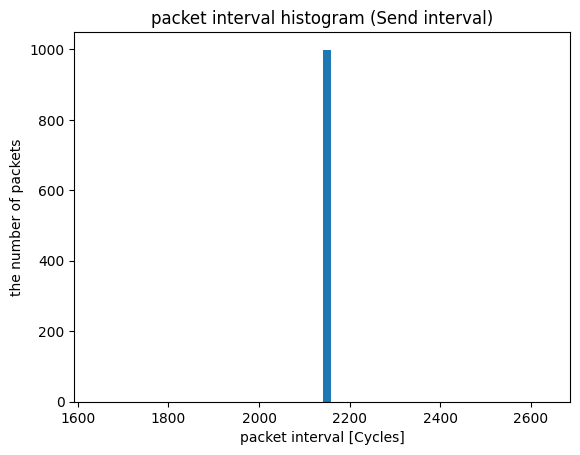

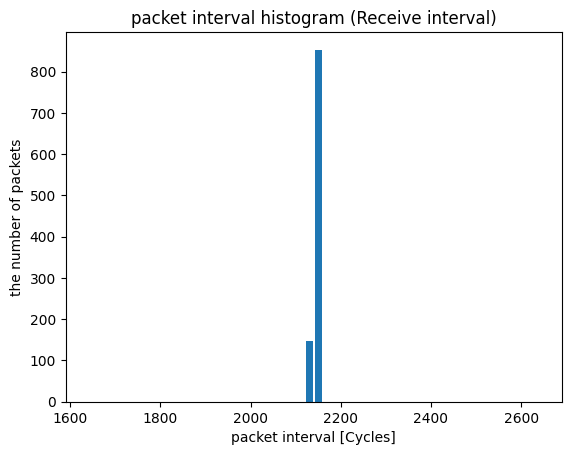

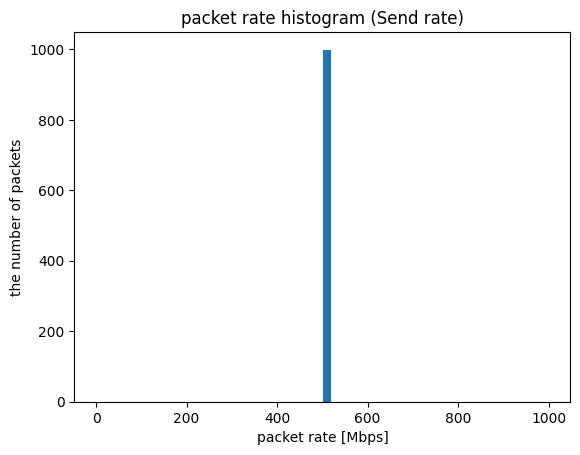

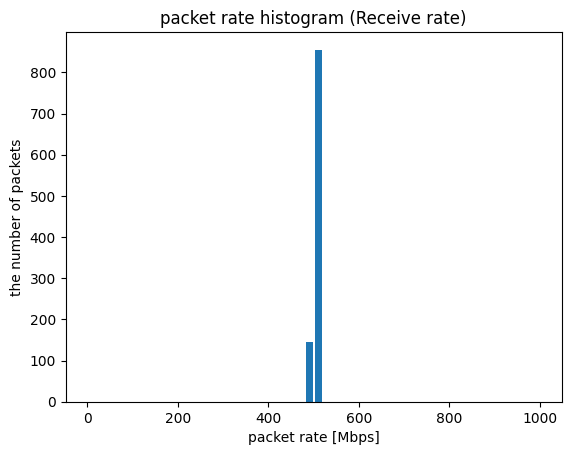

<Figure size 640x480 with 0 Axes>

In [32]:
draw_graph(send_stat, recv_stat, FREQ_MHZ, framesize)

## 3. Sends frames at a random transmission rate that follows an exponential distribution
Next, we calculate `target_cycle` using the exponential distribution with the specified average rate.

### 3-A. Generate random numbers that follow an exponential distribution

We use the scipy function expon.rvs() to generate the array of exponential distributions.  
The $ \lambda $ is the number of frames sent per second, and we set the $ \frac{1}{\lambda} $ to the `scale` parameter of expon.rvs().  
The random number generated is the time from the beginning of the frame to the beginning of the next frame, expressed in seconds, so you can convert it to cycles by dividing it by the time in a cycle.

In [33]:
from scipy.stats import expon
import math
size_bits = framesize * BITS_PER_BYTE
exp_rate = average_rate_mbps * 1000 * 1000
num_frames_per_seconds = exp_rate / size_bits

p = expon.rvs(scale=1/num_frames_per_seconds, size=num_frames, random_state=0)
target_cycles = p / NS_PER_CYCLE * 1000 * 1000 * 1000

However, the minimum value of the random number generated is zero, so the transfer rate becomes infinite at this point.

In [34]:
exp_rate = average_rate_mbps * 1000 * 1000
num_frames_per_seconds = exp_rate / size_bits

p = expon.rvs(scale=1/num_frames_per_seconds, size=1000, random_state=0)
target_cycles = p / NS_PER_CYCLE * 1000 * 1000 * 1000

tx_rates_mbps = 1000 / target_cycles * framesize
print(max(tx_rates_mbps))

915559.7715221521


Therefore, by specifying the minimum number of seconds between the start of one frame and the start of the next, `min_period_sec`, in the `loc` parameter of exponent.rvs(), you can limit the maximum transfer speed.

In [35]:
# Calculate the offset value for an exponential distribution
min_period_sec = min_cycle * NS_PER_CYCLE / 1000.0 / 1000.0 / 1000.0

p = expon.rvs(loc = min_period_sec, scale=1/num_frames_per_seconds - min_period_sec, size=num_frames, random_state=0)
target_cycles = (p / NS_PER_CYCLE * 1000 * 1000 * 1000 + 0.5).astype(np.uint32)

tx_rates_mbps = 1000 / target_cycles * framesize
print(max(tx_rates_mbps))

980.7516040329972


### 3-B. Prepare send frames (Exponential distribution)

The processing after calculating `target_cycles` is the same as for the constant rate.

In [36]:
prepare_frames(target_cycles)

Dump the first 10 frames of the frame information pushed to ef_crafter.

In [37]:
for frame in crafter.get_frames(port=0, max_num=10):
    print(frame)

Frame0000.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0001.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=770).Nop()
Frame0002.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0003.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1253).Nop()
Frame0004.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0005.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=903).Nop()
Frame0006.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0007.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=761).Nop()
Frame0008.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=1024)
Frame0009.ETHER(dst=2, src=1).IPV4(dst=2, src=1).UDP(dst=2000, src=1000).Payload(length=513).Nop()


### 3-C. Send frames from port0 to port1, in repeat mode

In [38]:
port = 0
bit_mask = 1 << port
crafter.reset(bit_mask)
crafter.set_repeat(bit_mask)
crafter.start(bit_mask)
crafter.wait_until(port, num_frames)

### 3-D. Transfer the recorded timestamps to the host computer

In [39]:
capture0.wait(num_frames)
capture1.wait(num_frames)

# Reset ef_crafter to stop repeating
crafter.reset(0xff)

Read timestamps from hardware.

In [40]:
send_stat = capture0.read_timestamp(num_frames)
recv_stat = capture1.read_timestamp(num_frames)

send_stat.save_to_csv("3_3_send.csv")
recv_stat.save_to_csv("3_3_recv.csv")

capture0.reset()
capture1.reset()

read_timestamp: |██████████████████████████████| 1000 / 1000
read_timestamp: |██████████████████████████████| 1000 / 1000


### 3-E. Evaluate latency and throughput

Calculates throughput and latency using the transmit and receive timestamps of frames sent from port 0.

In [41]:
# Show statistics information of the timestamp difference
recv_stat.subtract(send_stat).summary(freq_mhz=FREQ_MHZ, name='Latency: Exponential distribution', f=sys.stdout)

start_timestamp = min(send_stat.get_timestamps())
end_timestamp = max(send_stat.get_timestamps())
duration_sec = (end_timestamp - start_timestamp) / (FREQ_MHZ * 1000 * 1000)

l2_size, l7_size = valid_frame.get_length()
print(f'l2 size of Frame0: {l2_size}, l7 size of Frame0: {l7_size}')
def timestamp_to_size(tid: int) -> int:
    return l2_size

tsn_efcc.TimestampStatistic.summary_bandwidth(send_stat, recv_stat, FREQ_MHZ, timestamp_to_size, duration_sec=duration_sec, name='Throughput: Exponential distribution', f=sys.stdout)

--------------------------------
TimestampStat(Latency: Exponential distribution): id range = [0x00000000:0x0000075c]
Minimum Timestamp: 1528.00 ns
Maximum Timestamp: 1544.00 ns
Average Timestamp: 1536.72 ns
Stddev Timestamp: 3.20 ns
l2 size of Frame0: 1070, l7 size of Frame0: 1024
--------------------------------
TimestampStat(Throughput: Exponential distribution): id range = [0x00000000:0x0000075c]
# of sent frames: 1000
send rate: 499.666 Mbps
# of recvd frames: 1000
recv rate: 499.666 Mbps
# of dropped frames: 0
drop rate: 0.000 %


Check the histogram to see if the transmission interval is constant.

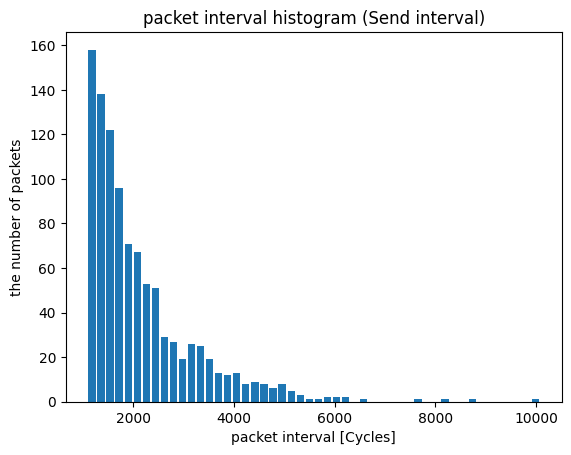

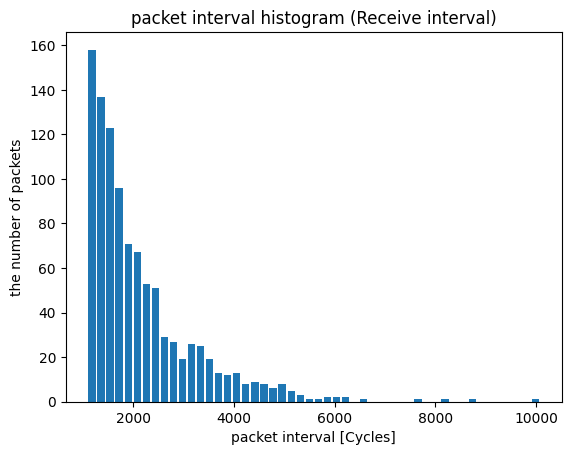

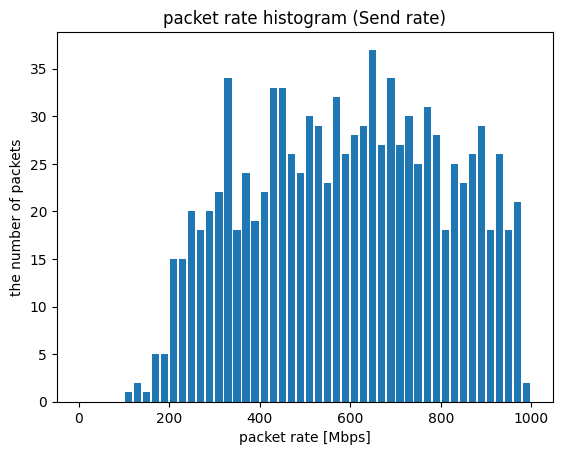

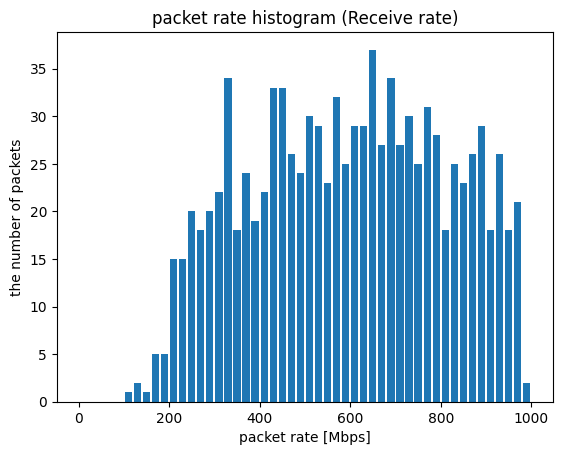

<Figure size 640x480 with 0 Axes>

In [42]:
draw_graph(send_stat, recv_stat, FREQ_MHZ, framesize)